## Image classification using Food-101 dataset

### Task description
1. Grab the dataset from https://huggingface.co/datasets/food101
2. Implement a convolutional neural network for multiclass image classification.
3. Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html or `dl_lab5` for inspiration.

In [3]:
!pip install datasets

   ---------------------------------------- 0.0/542.0 kB ? eta -:--:--
   ------ --------------------------------- 92.2/542.0 kB 2.6 MB/s eta 0:00:01
   ------------------- -------------------- 266.2/542.0 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------  532.5/542.0 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 542.0/542.0 kB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/401.2 kB ? eta -:--:--
   --------------------------------- ------ 337.9/401.2 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 401.2/401.2 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/143.5 kB ? eta -:--:--
   ---------------------------------------- 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------------------------------------- 116.3/116.3 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    

In [2]:
import torch
import numpy as np
import torchvision 
from torchvision import transforms 
import pyarrow.parquet as pq
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from IPython.display import display

In [53]:
def read_parquet(file):
    desired_size = (30, 30)
    table = pq.read_table(file)
    image_bytes = table.column('image').to_pylist()
    labels_in = table.column('label').to_pylist()

    transform = transforms.Compose([
        transforms.Resize(desired_size),
        transforms.ToTensor()
    ])

    images = []
    labels = []
    for i,img_bytes in enumerate(image_bytes):
        image = Image.open(io.BytesIO(img_bytes['bytes']))
        image = transform(image)
        if image.size() == torch.Size([3, 30, 30]):
            labels.append(labels_in[i])
            images.append(image)
    train_labels = torch.tensor(labels)
    train_images = torch.stack(images)
    return TensorDataset(train_images, train_labels)
    

In [54]:
for i in range(8):
    if i == 0:
        train_dataset = read_parquet(f"train-0000{i}-of-00008.parquet")
    else:
        train_dataset += read_parquet(f"train-0000{i}-of-00008.parquet")
for i in range(3):
    if i == 0:
        test_dataset = read_parquet(f"validation-0000{i}-of-00003.parquet")
    else:
        test_dataset += read_parquet(f"validation-0000{i}-of-00003.parquet")

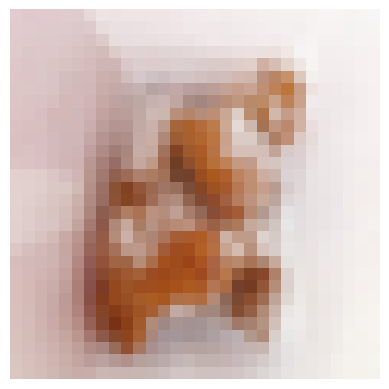

In [55]:
import matplotlib.pyplot as plt
import numpy as np
img_tensor = train_dataset[7][0]
img_np = img_tensor.numpy().transpose(1, 2, 0)
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [56]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(test_dataset, batch_size, shuffle=False)

In [57]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 3, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [58]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 3, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [59]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 101)) 

In [60]:
device = torch.device("cuda")

model = model.to(device) 

In [61]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.0537 val_accuracy: 0.1002
Epoch 2 accuracy: 0.1032 val_accuracy: 0.1387
Epoch 3 accuracy: 0.1375 val_accuracy: 0.1726
Epoch 4 accuracy: 0.1610 val_accuracy: 0.1827
Epoch 5 accuracy: 0.1832 val_accuracy: 0.1924
Epoch 6 accuracy: 0.2024 val_accuracy: 0.1952
Epoch 7 accuracy: 0.2200 val_accuracy: 0.1982
Epoch 8 accuracy: 0.2386 val_accuracy: 0.2036
Epoch 9 accuracy: 0.2565 val_accuracy: 0.2039
Epoch 10 accuracy: 0.2736 val_accuracy: 0.2003


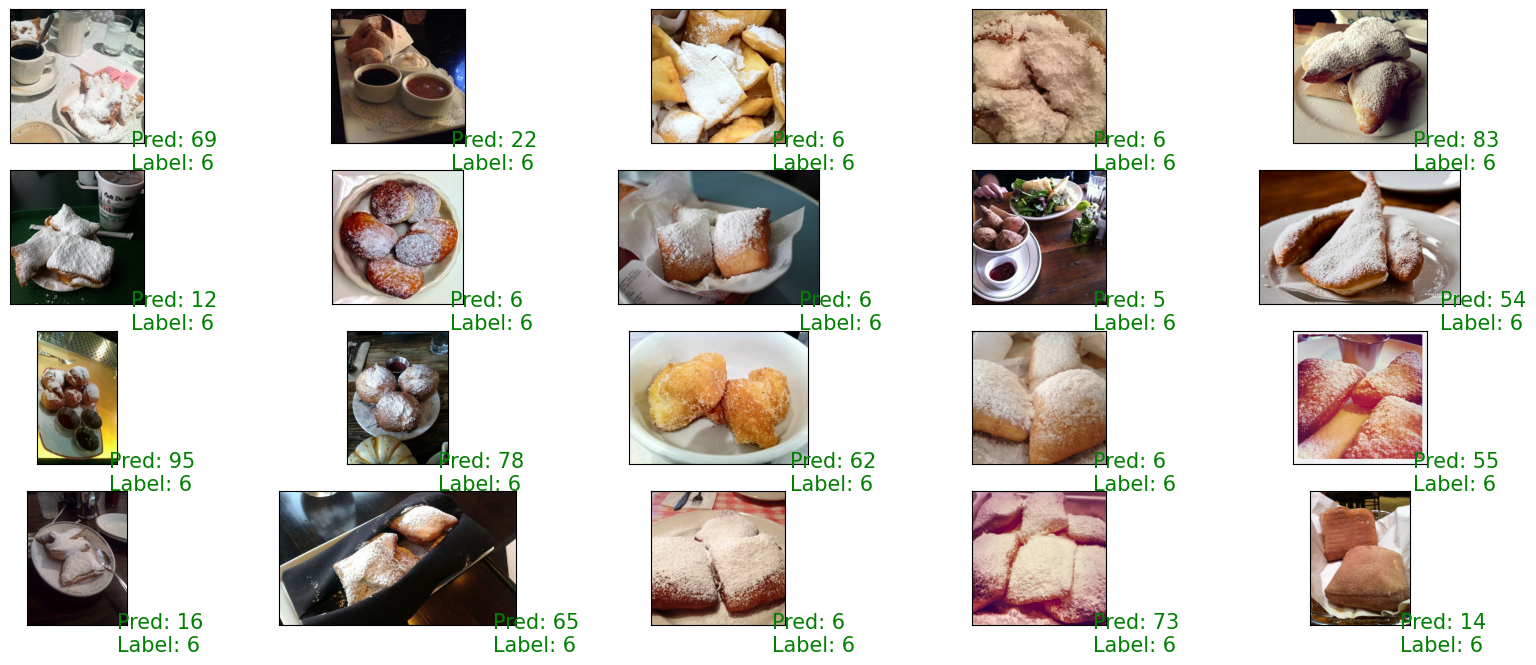

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import torch
from torchvision import transforms
import pyarrow.parquet as pq

table = pq.read_table("validation-00000-of-00003.parquet")
image_bytes = table.column('image').to_pylist()
labels_in = table.column('label').to_pylist()

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Візуалізація зображень і прогнозів
fig = plt.figure(figsize=(20, 8))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1)  # Змінено на 4 ряди по 5 зображень
    ax.set_xticks([]); ax.set_yticks([])
    
    # Зчитування байтів зображення
    img_bytes = image_bytes[i]['bytes']  # Витягуємо байти з словника
    img = Image.open(io.BytesIO(img_bytes))
    
    # Перетворення зображення
    img_transformed = transform(img).unsqueeze(0).to(device)
    
    # Прогнозування
    pred = model(img_transformed)
    y_pred = torch.argmax(pred).item()
    
    # Відображення оригінального зображення
    ax.imshow(img)
    ax.text(0.9, 0.1, f'Pred: {y_pred}\nLabel: {labels_in[i]}', 
            size=15, color='Green',
            horizontalalignment='left',
            verticalalignment='top', 
            transform=ax.transAxes)

plt.show()
